In [22]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.metrics import categorical_accuracy


# Warnings'ı gizle
warnings.filterwarnings("ignore")

In [23]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [24]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [25]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [26]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [27]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [28]:
# #### Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS, 3)

# ### Eğitim ve Doğrulama Örnek Sayıları
train_samples_num = get_files(train_path)
val_samples_num = get_files(valid_path)
print(train_samples_num)
print(val_samples_num)


# Birkaç yararlı değeri bildirme
epochs = 50
num_train_samples = train_samples_num
num_val_samples = val_samples_num
train_batch_size = 64
val_batch_size = 64
image_size = 224

# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_samples_num // train_batch_size
val_steps = val_samples_num // val_batch_size

36529
3673


In [29]:
# Üreticileri ayarlama
data_gen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size, image_size),
                                             batch_size=train_batch_size)

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size, image_size),
                                             batch_size=val_batch_size)

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False)

Found 36529 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.


In [30]:
# Bir MobileNet modeli oluşturma
mobile = keras.applications.mobilenet.MobileNet()

# Modeli düzenleme
# Modelin son 5 katmanını hariç tutma
x = mobile.layers[-6].output
# Tahminler için dropout ve dense layer ekleme

# Reshape or Flatten the output to 2D
x = Flatten()(x) # Add this line to flatten the output

x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Yeni çıktılı bir model oluşturma
model = Model(inputs=mobile.input, outputs=predictions)

# Modeldeki yeni katmanların özetine bakma
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,580,103 (13.66 MB)

 Trainable params: 3,558,215 (13.57 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [31]:
# Eğitilmeyen katmanların ağırlıklarını dondurma (sadece son 23'ünü eğitme)
for layer in model.layers[:-23]:
    layer.trainable = False

In [32]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

# Modeli melanoma daha duyarlı hale getirmek için ağırlık ekleme
# class_weights={
#     0: 1.0,  # akiec
#     1: 1.0,  # bcc
#     2: 1.0,  # bkl
#     3: 1.0,  # df
#     4: 3.0,  # mel
#     5: 1.0,  # nv
#     6: 1.0,  # vasc
# }

# Save edilmiş model için dosya yolunu bildirme
filepath = "C:/Users/esraa/Desktop/base_dir/mobilNet_model.keras"

# Modelin en iyi versiyonunu save etmek için bir checkpoint bildirme
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Öğrenme durgunlaştıkça öğrenme oranını azaltma
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=4,
                              verbose=1,
                              mode='max',
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [33]:
# Modeli uydurma
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    # class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5036 - loss: 10.2720
Epoch 1: val_loss improved from -inf to 3.94015, saving model to C:/Users/esraa/Desktop/base_dir/mobilNet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 1187s 2s/step - categorical_accuracy: 0.5039 - loss: 10.2592 - val_categorical_accuracy: 0.4550 - val_loss: 3.9401 - learning_rate: 0.0100
Epoch 2/50
  1/570 ━━━━━━━━━━━━━━━━━━━━ 17:41 2s/step - categorical_accuracy: 0.7188 - loss: 0.8494
Epoch 2: val_loss did not improve from 3.94015
570/570 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - categorical_accuracy: 0.7188 - loss: 0.8494 - val_categorical_accuracy: 0.4627 - val_loss: 3.8289 - learning_rate: 0.0100
Epoch 3/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7977 - loss: 0.5400
Epoch 3: val_loss improved from 3.94015 to 6.06061, saving model to C:/Users/esraa/Desktop/base_dir/mobilNet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step - categorical_accuracy: 0.7977 - loss: 0

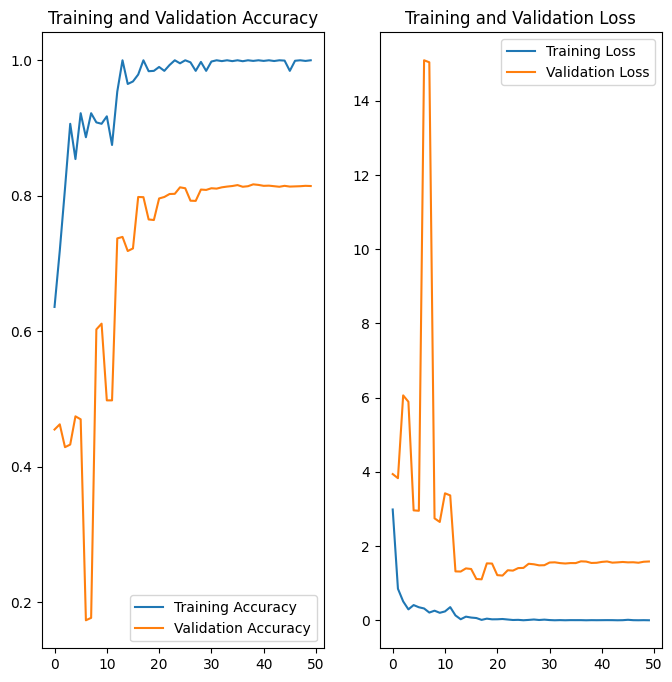

In [34]:
#Eğitim sonuçlarını görselleştirme.
#Ağı eğittikten sonra elde edilen sonuçları görselleştirme.

acc = history.history['categorical_accuracy']# Eğitim doğruluğu
val_acc = history.history['val_categorical_accuracy']# Doğrulama doğruluğu

loss = history.history['loss']# Eğitim kayb,
val_loss = history.history['val_loss'] # Doğrulama kaybı

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


58/58 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Precision: 0.8264554446228615
Recall: 0.815137489790362
F1 Score: 0.8159080855302773


In [36]:
# Modeli hesaplama
val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

model.load_weights(filepath)

57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - categorical_accuracy: 0.7394 - loss: 2.2716
val_loss: 1.583361268043518
val_cat_acc: 0.8144188523292542


In [37]:
# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, verbose=1)

58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step


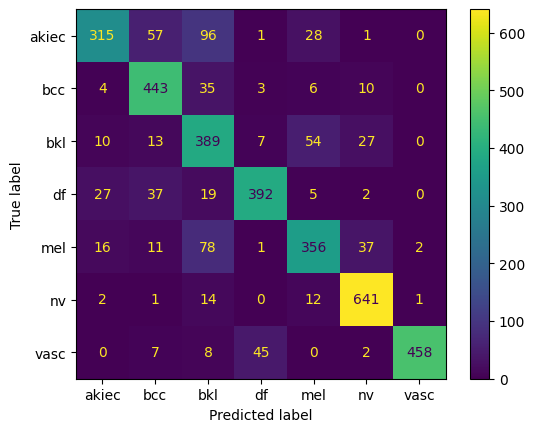

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrisi oluşturma
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Confusion matrisini görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()

Normalize edilmiş Confusion matris
[[0.10040161 0.         0.         0.         0.         0.
  0.89959839]
 [0.00199601 0.00998004 0.         0.         0.         0.
  0.98802395]
 [0.002      0.         0.         0.         0.         0.
  0.998     ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.00199601
  0.99800399]
 [0.         0.         0.         0.         0.00149031 0.09538003
  0.90312966]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


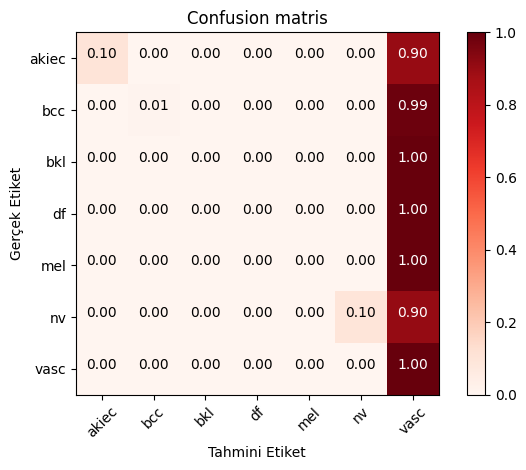

In [39]:
# Confusion matrisi oluşturan fonksiyon
def plot_confusion_matrix(cm, classes, normalize=True,
                          title='Confusion matris', cmap=plt.cm.Reds):

    #Bu fonksiyon, karışıklık matrisini yazdırır ve çizer. Normalleştirme, 'normalize=True' ayarlanarak uygulanabilir.

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalize edilmiş Confusion matris")
    else:
        print('Normalize edilmemiş Confusion matris')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmini Etiket')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

image shape: (224, 224, 3)


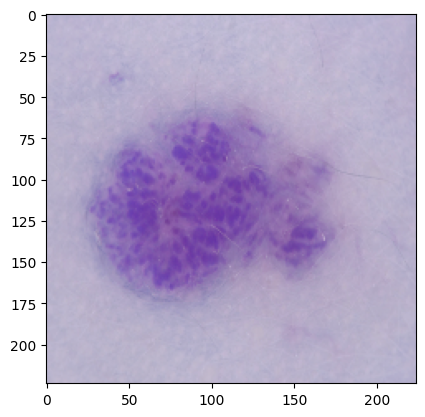

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
[[2.3087391e-13 7.4472133e-14 2.5802987e-18 2.2547303e-15 2.9931206e-13
  5.1658217e-13 1.0000000e+00]]
vasc


In [40]:
# read sample test image
import cv2
img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])


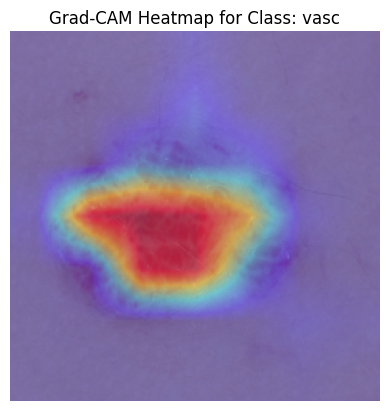

In [41]:

def grad_cam(model, img, layer_name, label_index):
    # Grad-CAM modeli
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, label_index]

    # Gradyanları hesaplama
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(conv_outputs, weights)

    # Normalize etme
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))

    return cam

# Grad-CAM için son konvolüsyonel katman
last_conv_layer_name = 'conv_pw_13_relu'

# Grad-CAM hesaplama
heatmap = grad_cam(model, img_test, last_conv_layer_name, predicted_label)

# Orijinal görüntü üzerine ısı haritasını bindirme
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_scaled, 0.6, heatmap, 0.4, 0)

# Görselleştirme
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap for Class: {cm_plot_labels[predicted_label]}")
plt.axis('off')
plt.show()


In [42]:
import tensorflow as tf

# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/mobilNet_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/mobilNet_model.h5")
